In [1]:
#----------------------------
# import libraries
#----------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
def reserve_test_set(df, ratio):
    # shuffle array
    df = shuffle(df)
    # calculate number of samples in test set
    N = round( ratio * df.shape[0] )
    # split dataframe
    test_set = df.iloc[:N, :]
    df = df.iloc[N:, :]
    return test_set, df

In [291]:
# path to save figures
path = 'figures/ex2/'
# read training data
X_train_df = pd.read_fwf('X_train.txt', header=None)
y_train_df = pd.read_csv('y_train.txt')
# read test data
X_test_df = pd.read_fwf('X_test.txt', header=None)
y_test_df = pd.read_csv('y_test.txt')

In [292]:
# convert DataFrame to NumPy array
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_train_raw = y_train_df.to_numpy()
y_test_raw = y_test_df.to_numpy()

**output** <br>
1 – caminhada <br>
2 – subindo escadas <br>
3 – descendo escadas <br>
4 – sentado <br>
5 – em pé <br>
6 – deitado <br>
<br>
**one-hot enconding** <br>
[1 0 0 0 0 0]$^T$: walking <br>
[0 1 0 0 0 0]$^T$: climbing stairs <br>
[0 0 1 0 0 0]$^T$: going down stairs <br>
[0 0 0 1 0 0]$^T$: seated <br>
[0 0 0 0 1 0]$^T$: standing <br>
[0 0 0 0 0 1]$^T$: lying <br>


In [171]:
from sklearn.preprocessing import OneHotEncoder

In [172]:
enc = OneHotEncoder(categories='auto')
enc.fit(y_train)
def one_hot_encoder(y):
    return enc.transform(y).toarray()
def one_hot_decoder(y):
    return enc.inverse_transform(y)

In [293]:
# one-hot encoding
y_train = one_hot_encoder(y_train_df)
y_test = one_hot_encoder(y_test_df)

In [175]:
# size of dataset
N = X_test.shape[0]
# number of features
K = X_test.shape[1]
# number of classes
C = len(enc.categories_[0])

In [176]:
# w = [ w0(0) w0(1) ... w0(C)]
#     [ w1(0) w1(1) ... w1(C)]
#     [ ...    ...  ...  ... ]
#     [ wK(0) wK(1) ... wK(C)]


# phi: (N x K)
#   w: (K x C)

# (phi @ w): (N x C) --> expoentes para softmax

In [282]:
# create weights matrix
w = np.random.rand(K+1, C)
# create phi matrix
phi = np.insert(X_train, 0, [1], axis=1)

In [286]:
def softmax(phi, w):
    # exponent matrix --> (phi @ w)
    exp_matrix = phi @ w
    # terms of exponent matrix --> exp(phi @ w)
    numerator = np.exp(exp_matrix)
    # sum of terms in exponent matrix --> exp(phi@w0) + ... + exp(phi@wK)
    # denominator of softmax function
    sum_numerator = np.sum(numerator, axis=1).reshape(-1,1)
    # copy sum (Nx1) in (K+1) columns
    denominator = np.repeat(sum_numerator, C, axis=1)
    # calculate softmax
    ŷ = numerator/denominator
    return ŷ

In [295]:
#gradient = (y - ŷ)

In [500]:
# dataframe to numpy
features = df.to_numpy()

In [501]:
# split data according to the label
df_male = df[df['label'] == 1]
df_female = df[df['label'] == 0]

In [502]:
ratio = 0.2
# shuffle and reserve set for test
df_test_female, df_female = reserve_test_set(df_female, ratio)
df_test_male, df_male = reserve_test_set(df_male, ratio)

In [503]:
# concatenate and shuffle test set
df_test_set = [df_test_male, df_test_female]
df_test_set = pd.concat(df_test_set)
df_test_set = shuffle(df_test_set)

In [504]:
# concatenate and shuffle test set
df_train_set = [df_male, df_female]
df_train_set = pd.concat(df_train_set)
df_train_set = shuffle(df_train_set)

In [505]:
# data standardization: x' = (x - u) / s
scaler = StandardScaler()
#-------------------
# in training set
#-------------------
# remove column 'label' from x data
df_train_set_x = df_train_set.drop('label', axis=1)
# define column 'label' as output y
df_train_set_y = df_train_set.loc[:,'label']
# perform standardization with x data
scaler.fit(df_train_set_x)
train_set = scaler.transform(df_train_set_x)
#-------------------
# in test set
#-------------------
# remove column 'label' from x data
df_test_set_x = df_test_set.drop('label', axis=1)
# define column 'label' as output y
df_test_set_y = df_test_set.loc[:,'label']
# perform standardization with x data
scaler.fit(df_test_set_x)
test_set = scaler.transform(df_test_set_x)

In [507]:
def logistic_function(x):
    N = x.shape[0]
    ŷ = np.zeros(shape=(N,1))
    for i in range(N):
        ŷ[i] = 1 / (1 + np.exp(x[i]))
    return ŷ

In [508]:
def iterate(x, y, N, phi, w, alpha):
    # calculate estimated output
    ŷ = logistic_function(- phi @ w)
    # calculate gradient
    error = y - ŷ
    gradient = -1/N * (error.T @ phi)
    # calculate RMSE
    rmse = np.mean(error * error)
    w = w - (alpha * gradient.T)
    return w, rmse

In [509]:
def train(x, y, alpha=1e-2, tolerance=1e-4):
    # alpha: step size
    # tolerance: stop criteria
    #-----------------------------
    # create weights array randomly
    w = np.random.rand(x.shape[1]+1)
    w = w.reshape(1,len(w)).T
    # arrays initialization
    N = x.shape[0]
    phi = np.insert(x, 0, [1], axis=1)
    e = []
    #-----------------------------
    # run algorithm first time
    w, rmse = iterate(x, y, N, phi, w, alpha)
    diff = rmse
    e.append(rmse)
    #-----------------------------
    # iterate until convergence
    while (diff > tolerance):
        w, rmse = iterate(x, y, N, phi, w, alpha)
        diff = e[-1] - rmse
        e.append(rmse)
    #-----------------------------        
    return w, e

In [510]:
def predict_class(ŷ, threshold):
    for i in range(len(ŷ)):
        if (ŷ[i] > threshold):
            ŷ_final[i] = 1
        else:
            ŷ_final[i] = 0
    return ŷ_final

In [511]:
# prepare input and output of model for training set
y = pd.DataFrame.to_numpy(df_train_set_y)
y = y.reshape(len(y),1)
x = train_set

In [512]:
w, error = train(x, y, tolerance=1e-7)

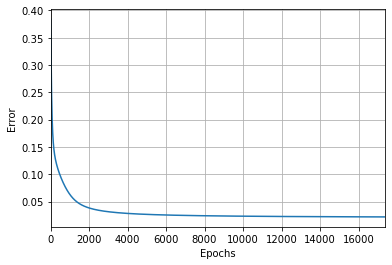

In [529]:
plt.plot(error)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

In [530]:
# prepare input and output of model for test set
y = pd.DataFrame.to_numpy(df_test_set_y)
y = y.reshape(len(y),1)
x = test_set

In [531]:
# form phi matrix
phi = np.insert(x, 0, [1], axis=1)
N = x.shape[0]
# estimated output
ŷ = logistic_function(- phi @ w)

In [532]:
fpr, tpr, thresholds = roc_curve(y, ŷ)

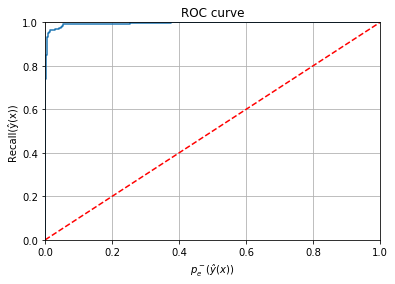

In [533]:
# plot curves
lin = np.linspace(0,1,1001)
plt.plot(fpr, tpr)
plt.plot(lin, lin, 'r--')
# labels
from matplotlib import rc
plt.xlabel('$p_e^-(ŷ(x))$')
plt.ylabel('Recall(ŷ(x))')
# title
plt.title('ROC curve')
# adjust plot
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.autoscale(axis='y', tight=True)
plt.savefig(path + 'ROC', dpi=300)
plt.show()

In [551]:
F_score = []
threshold = np.linspace(0,1,1001)
for i in threshold:
    output = predict_class(ŷ, i)
    F_score.append(f1_score(y, output))

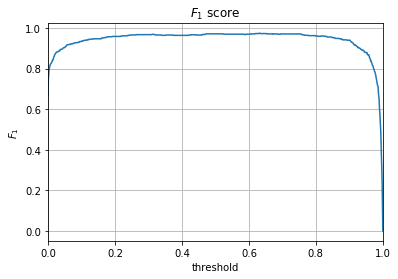

In [552]:
# plot curves
plt.plot(threshold, F_score)
# axis labels
plt.xlabel('threshold')
plt.ylabel('$F_1$')
# title
plt.title('$F_1$ score')
# adjust plot
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.savefig(path + 'F1_score', dpi=300)
plt.show()

In [553]:
index = F_score.index(max(F_score))
print('threshold for maximum F1 score =', threshold[index])
print('F1 score max =', F_score[index])

threshold for maximum F1 score = 0.631
F1 score max = 0.9745222929936306


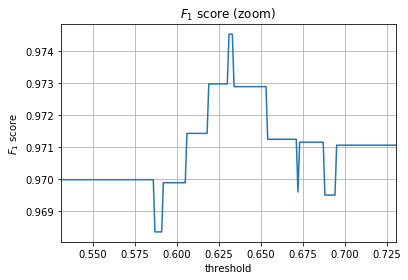

In [554]:
# plots
plt.plot(threshold[max(0,index-100):min(len(F_score)-1,index+100)], F_score[max(0,index-100):min(len(F_score)-1,index+100)])
# axis label
plt.xlabel('threshold')
plt.ylabel('$F_1$ score')
# axis adjust
plt.autoscale(axis='x', tight=True)
# title
plt.title('$F_1$ score (zoom)')
# add grid
plt.grid(True)
plt.savefig(path + 'F1_score_zoom', dpi=300)
plt.show()

In [555]:
ŷ_final = predict_class(ŷ, threshold[index])
confusion_matrix(y, ŷ_final)

array([[312,   5],
       [ 11, 306]])

In [556]:
accuracy_score(y, ŷ_final)

0.9747634069400631